In [ ]:
notebook = input('Номер ноутбука: ')

In [7]:
import sys
import math
import time
sys.path.insert(0, r'/home/danis/work/python_works/gamma_4/Scripts')
sys.path.insert(0, r'D:\Учеба\Практика\Диплом\gamma_4\Scripts')
import numpy as np
import pandas as pd
from materials import*
import matplotlib.pyplot as plt
from garipov_deconvolution import get_coeff_simpson
from garipov_deconvolution import Gold

Минимальная энергия: 1e-3
windows (w) or linux (l): l


In [8]:
linspace1 = np.linspace(0.035, 0.1, 25, dtype=np.float32)
linspace2 = np.geomspace(0.11, 3, 25, dtype=np.float32)

beams_energyes = []
beams_energyes.extend(linspace1)
beams_energyes.extend(linspace2)

In [9]:
m = 40
target = R(Material(m), 0.01)

brems = [target.brem(beams_energy) for beams_energy in beams_energyes]
brems_e = [brem * en for brem in brems]

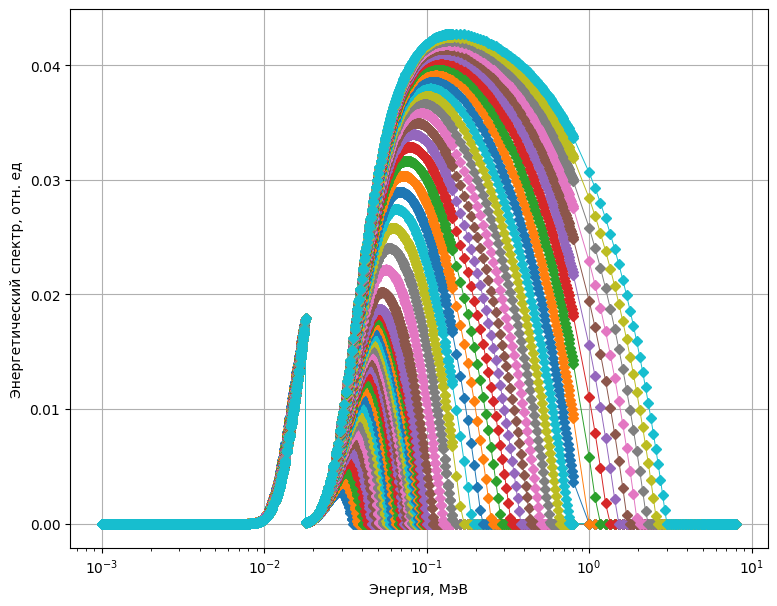

In [10]:
fig, ax = plt.subplots(figsize=(9, 7))

for br in brems_e:
    ax.plot(en, br, ls='-', marker='D', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)

ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)

ax.grid(True)

# fig.savefig('Тормозной спектр.jpg', bbox_inches='tight')

In [11]:
n = 11

In [12]:
# Индексы К скачков
EDGE = []
for i in range(1, len(en)):
    if en[i - 1] == en[i]:
        EDGE.append(i - 1)

In [13]:
EDGE.remove(EDGE[EDGE.index(Material(m).k_index())])

Спектральные характеристики чувствительности каналов

In [14]:
def ross_by_k_level(num_1, num_2, level):
    t_2 = Material(num_2).lt(level)
    f_2 = R(Material(num_2), Material(num_2).lt(level)).f()
    t_1 = Material(num_1).lt(R(Material(num_2), Material(num_2).lt(level)).f()[Material(num_1).k_index()])
    f_1 = R(Material(num_1), t_1).f()
    return f_2 - f_1

In [15]:
def signals_from_one_spectrum(spectrum, matrix, new_en):
    
    start_time = time.time()
    signals = []
        
    # для каждой строки в матрице
    for row in matrix:
        # значение одного сигнала
        signal = sum(row * np.interp(new_en, en, spectrum))
        signals.append(signal)
        
    return signals

In [16]:
def func_to_optimize(level, spectrum):
    start_time = time.time()
    resp_ross = [ross_by_k_level(i, i+1, level) for i in range(n, 100)]
    new_en = get_coeff_simpson(resp_ross[0], en, EDGE)[1]
    
    Matrixs = []
    for response in resp_ross:
        Matrixs.append(get_coeff_simpson(response, en, EDGE)[0])
        
    signals_simpson = signals_from_one_spectrum(spectrum, Matrixs, new_en)
    
    sp = [0 for i in range(len(resp_ross))]
    norm = [0 for i in range(len(resp_ross))]
    decb = [0 for i in range(len(resp_ross))]
    dev = [0 for i in range(len(resp_ross))]

    new_en = get_coeff_simpson(resp_ross[0], en, EDGE)[1]
    sp, norm, dev = Gold(Matrixs, signals_simpson, en, spectrum, new_en, 1, 10000, w=True, d=False)[:3]
    print(f'{round((time.time() - start_time), 5)} секунд')
    return dev

In [17]:
from scipy.optimize import minimize

In [19]:
deviations = []
optimize_levels = []

init_level = 0.3
counter = 1

for brem in brems_e:
    start = time.time()
    result = minimize(lambda l: func_to_optimize(l, brem), x0=init_level, bounds=([0.05, 0.8],), method='TNC')
    optimize_levels.append(result.x)
    deviations.append(result.fun)
    print(f'ВЫПОЛНЕНО {counter}  из {len(brems_e)}, время: {round(time.time()-start, 6)} секунд')
    counter += 1


KeyboardInterrupt



In [118]:
np.save('Notebook_14_DEV_ross_m40.npy', deviations)

In [119]:
np.save('Notebook_14_OPTLEV_ross_m40.npy', optimize_levels)

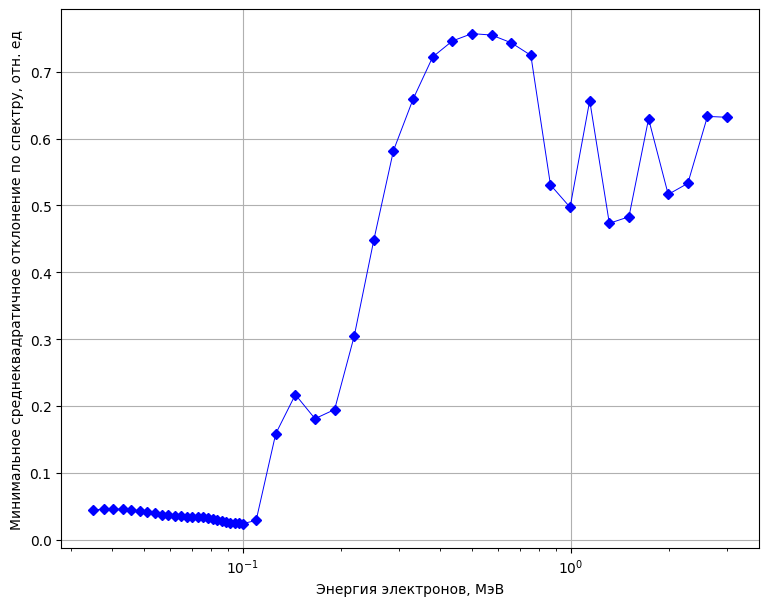

In [115]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(beams_energyes, deviations, ls='-', marker='D', lw='0.7', ms=5, color='blue')

# настройки графика
ax.set_xlabel('Энергия электронов, МэВ', fontsize=10)
ax.set_ylabel('Минимальное среднеквадратичное отклонение по спектру, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.grid(True)

# fig.savefig('Фильтры_Росса_минимум_ошибки_восстановления_от_энергии_электронов.jpg', bbox_inches='tight')

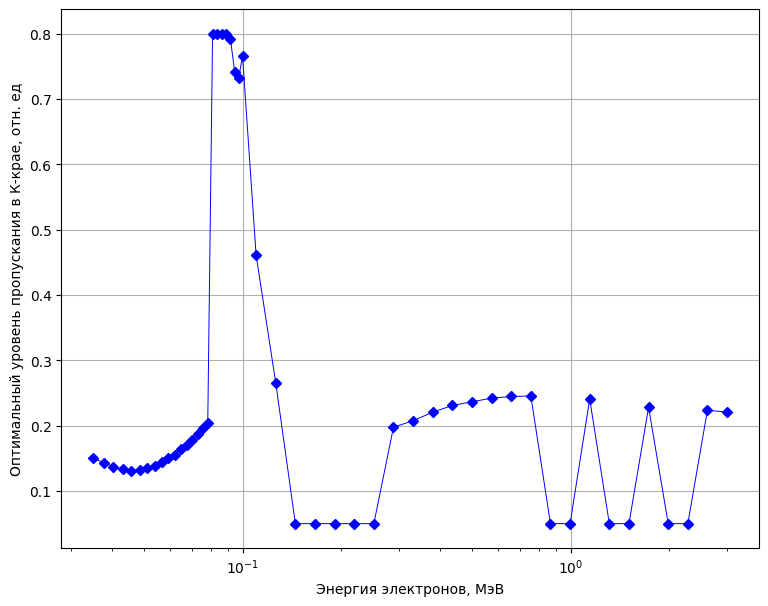

In [120]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(beams_energyes, optimize_levels, ls='-', marker='D', lw='0.7', ms=5, color='blue')

# настройки графика
ax.set_xlabel('Энергия электронов, МэВ', fontsize=10)
ax.set_ylabel('Оптимальный уровень пропускания в К-крае, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.grid(True)

# fig.savefig('Фильтры_Росса_минимум_ошибки_восстановления_от_энергии_электронов.jpg', bbox_inches='tight')